In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error

# Data Preprocessing

### Load Dataset

In [52]:
df = pd.read_csv('./data/AAPL.csv') 

In [53]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.407747,117258400.0
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.386473,43971200.0
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.358108,26432000.0
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366972,21610400.0
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.377609,18362400.0


In [54]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
9818,2019-11-19,267.899994,268.000000,265.390015,266.290009,266.290009,19041800.0
9819,2019-11-20,265.540009,266.079987,260.399994,263.190002,263.190002,26558600.0
9820,2019-11-21,263.690002,264.010010,261.179993,262.010010,262.010010,30348800.0
9821,2019-11-22,262.589996,263.179993,260.839996,261.779999,261.779999,16331300.0
9822,2019-11-25,262.709991,266.440002,262.519989,266.369995,266.369995,21005100.0


In [55]:
df.shape

(9823, 7)

In [56]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [57]:
df.isna().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [58]:
df.isna().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [59]:
df[df.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume
165,1981-08-10,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
df = df.dropna()

In [61]:
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [62]:
df.duplicated().sum()

np.int64(0)

### Feature Selection

In [63]:
# Convert the Date column to a datetime format and set it as the index.
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [64]:
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [65]:
df.shape

(9822, 6)

In [66]:
data = df[['Adj Close']].values

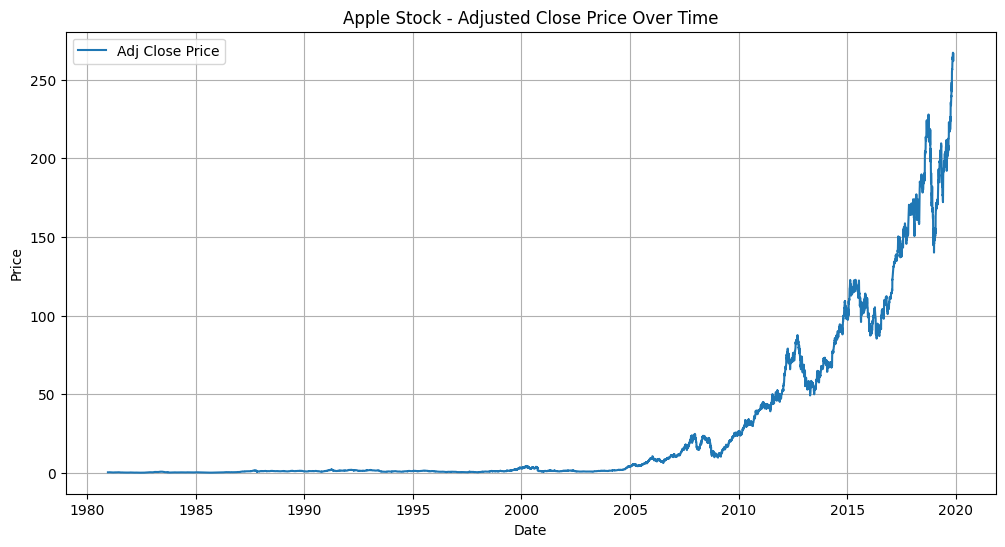

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(df['Adj Close'], label='Adj Close Price')
plt.title('Apple Stock - Adjusted Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

### Normalize data

In [68]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data

array([[9.43040495e-04],
       [8.63345877e-04],
       [7.57087635e-04],
       ...,
       [9.80932345e-01],
       [9.80070700e-01],
       [9.97265303e-01]], shape=(9822, 1))

### Create Sequences

In [69]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Reshape for RNN: (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X

array([[[9.43040495e-04],
        [8.63345877e-04],
        [7.57087635e-04],
        ...,
        [7.77013162e-04],
        [6.70754920e-04],
        [6.10982083e-04]],

       [[8.63345877e-04],
        [7.57087635e-04],
        [7.90293101e-04],
        ...,
        [6.70754920e-04],
        [6.10982083e-04],
        [5.64496678e-04]],

       [[7.57087635e-04],
        [7.90293101e-04],
        [8.30140410e-04],
        ...,
        [6.10982083e-04],
        [5.64496678e-04],
        [6.10982083e-04]],

       ...,

       [[7.67047727e-01],
        [7.80045113e-01],
        [7.79036736e-01],
        ...,
        [1.00000000e+00],
        [9.96965667e-01],
        [9.85352718e-01]],

       [[7.80045113e-01],
        [7.79036736e-01],
        [7.67682613e-01],
        ...,
        [9.96965667e-01],
        [9.85352718e-01],
        [9.80932345e-01]],

       [[7.79036736e-01],
        [7.67682613e-01],
        [7.80717441e-01],
        ...,
        [9.85352718e-01],
        [9.8093

### Split Dataset into Train & Test

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Model Development

Define SimpleRNN & LSTM Architecture: 
1. Use Sequential from tensorflow.keras to build a SimpleRNN/LSTM model.

Layers used:
1. SimpleRNN/LSTM layer for learning sequential dependencies.
2. Dropout layer to prevent overfitting.
3. Dense layer to output the predicted stock price.

### SimpleRNN

In [71]:
rnn_model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    SimpleRNN(units=50, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

rnn_model.compile(optimizer='adam', loss='mean_squared_error')
rnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training - Use Early Stopping and ModelCheckpoint

In [72]:
early_stop = EarlyStopping(
    monitor='val_loss',       
    patience=5,               
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.keras',         
    monitor='val_loss',
    save_best_only=True,      
    mode='min',
    verbose=1
)

# Fit the model with validation split and callbacks
history = rnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/50
217/220 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0045e-04 
Epoch 1: val_loss improved from inf to 0.00060, saving model to best_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 2.9694e-04 - val_loss: 6.0087e-04
Epoch 2/50
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7341e-05
Epoch 2: val_loss improved from 0.00060 to 0.00004, saving model to best_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.7327e-05 - val_loss: 4.4665e-05
Epoch 3/50
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1468e-05
Epoch 3: val_loss improved from 0.00004 to 0.00003, saving model to best_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.1453e-05 - val_loss: 3.1975e-05
Epoch 4/50
218/220 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0126e-05
Epoch 4: val_loss did not improve from 0.00003
220/220 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.0099e-05 - val_loss: 7.1708e-05
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8619e-06
Epoch 

### LSTM

In [73]:
LSTM_model = Sequential([
    Input(shape=(X_train.shape[1],1)),
    LSTM(units=50, activation='tanh'),
    Dropout(0.2),
    Dense(units=1)
])

LSTM_model.compile(optimizer='adam', loss='mean_squared_error')
LSTM_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_lstm_model.keras', 
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train the LSTM model
history = LSTM_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.4188e-05
Epoch 1: val_loss improved from inf to 0.00002, saving model to best_lstm_model.keras
220/220 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 8.3682e-05 - val_loss: 2.2181e-05
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.7236e-06
Epoch 2: val_loss did not improve from 0.00002
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 4.7269e-06 - val_loss: 5.5537e-05
Epoch 3/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.3482e-06
Epoch 3: val_loss did not improve from 0.00002
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 4.3467e-06 - val_loss: 2.3813e-05
Epoch 4/20
219/220 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.7852e-06
Epoch 4: val_loss did not improve from 0.00002
220/220 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 3.7855e-06 - val_loss: 5.3083e-05
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 3.1861e-06
Epoch 5: val_loss did not improve from 0.00002
220/220 ━━━━━━━━━━━━━━━━━━━━ 7

# Model Evaluation & Prediction

### SimpleRNN Model to predict stock prices on the test set

In [75]:
rnn_model = load_model('best_model.keras', compile=False)

In [76]:
predicted_scaled = rnn_model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_scaled)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step  


In [77]:
mse_rnn = mean_squared_error(actual_prices, predicted_prices)
print(f"Mean Squared Error (MSE): {mse_rnn:.4f}")

Mean Squared Error (MSE): 109.5789


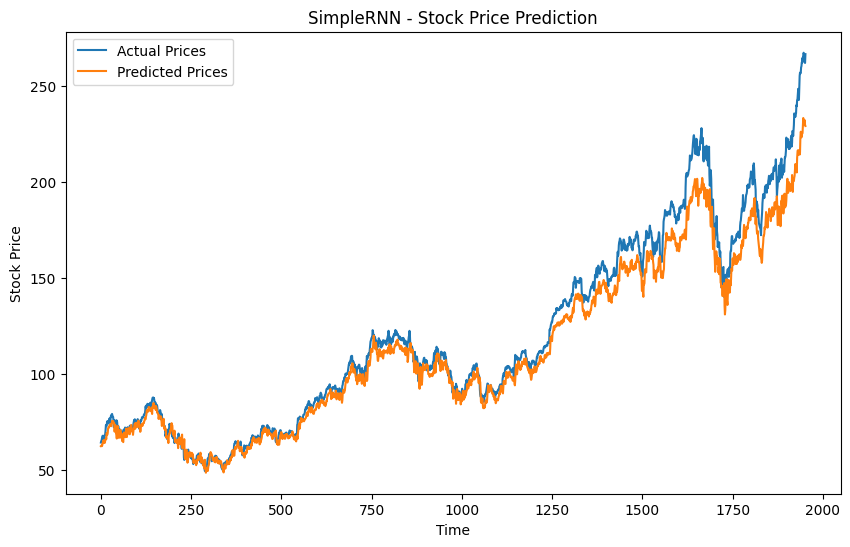

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('SimpleRNN - Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### LSTM to predict stock prices on test

In [79]:
lstm_model = load_model('best_lstm_model.keras', compile=False)
lstm_predicted_scaled = lstm_model.predict(X_test)
lstm_predicted_prices = scaler.inverse_transform(lstm_predicted_scaled)
lstm_actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step  


In [80]:
mse_lstm = mean_squared_error(lstm_actual_prices, lstm_predicted_prices)
print(f"Mean Squared Error (MSE): {mse_lstm:.4f}")

Mean Squared Error (MSE): 68.1335


In [81]:
X_test.shape

(1953, 60, 1)

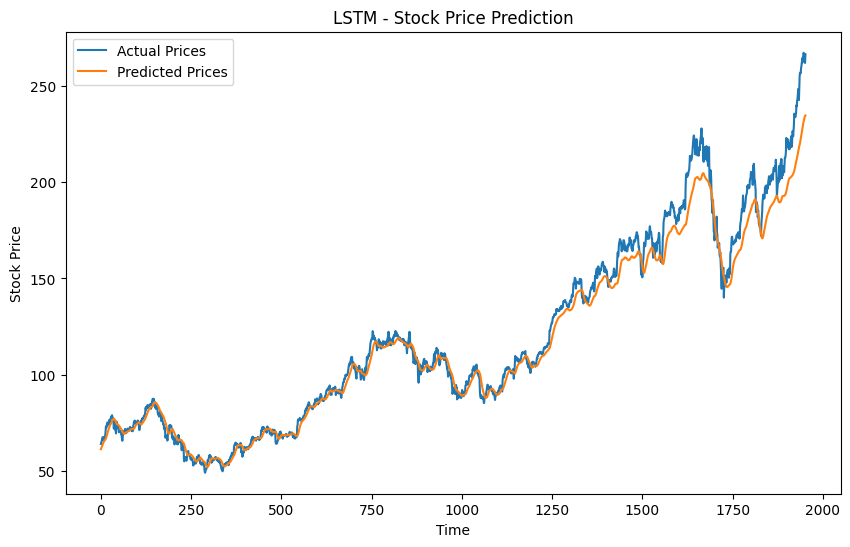

In [82]:
plt.figure(figsize=(10, 6))
plt.plot(lstm_actual_prices, label='Actual Prices')
plt.plot(lstm_predicted_prices, label='Predicted Prices')
plt.title('LSTM - Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# n days Stock Price Prediction using the trained Models - RNN and LSTM and full dataset

In [83]:
def predict_next_n_days_using_full_data(model, full_data, n_days, scaler, sequence_length=60):
    """ 
    Parameters:
        model: Trained LSTM
        full_data: Entire scaled dataset
        n_days: Number of future days to predict
        scaler: MinMaxScaler used to scale the data
        sequence_length: 60 time steps used in training

    Returns:
        Inverse-transformed predictions for the next n_days
    """
    predictions = []

    # Start with the last sequence_length days from the full dataset
    input_seq = full_data[-sequence_length:].copy()  # shape: (sequence_length, 1)

    for _ in range(n_days):
        input_reshaped = input_seq.reshape(1, sequence_length, 1)
        pred = model.predict(input_reshaped, verbose=0)[0][0]  # Predict one day ahead
        predictions.append(pred)

        # Update input sequence by appending the new prediction
        input_seq = np.append(input_seq[1:], [[pred]], axis=0)

    # Inverse transform predictions to original scale
    predictions = np.array(predictions).reshape(-1, 1)
    return scaler.inverse_transform(predictions)


## LSTM

### 1 Day Stock Price Prediction

In [84]:
full_data = scaled_data
predicted_1_day_lstm = predict_next_n_days_using_full_data(lstm_model, full_data, 1 , scaler)
actual_1_day = df['Adj Close'].values[-1:]
print(predicted_1_day_lstm)

[[234.80078]]


### 5 Days Stock Price Prediction

In [85]:
predicted_5_days_lstm = predict_next_n_days_using_full_data(lstm_model, full_data, 5 , scaler)
actual_5_days = df['Adj Close'].values[-5:]
actual_5_days = actual_5_days.reshape(-1, 1)

### 15 days Stock Price Prediction

In [86]:
predicted_15_days_lstm = predict_next_n_days_using_full_data(lstm_model, full_data , 15 , scaler)
actual_15_days = df['Adj Close'].values[-15:]
actual_15_days = actual_15_days.reshape(-1, 1)

## RNN

### 1 Day Stock Price Prediction

In [87]:
full_data = scaled_data
predicted_1_day_rnn = predict_next_n_days_using_full_data(rnn_model, full_data, 1 , scaler)
print(predicted_1_day_rnn)

[[226.86548]]


### 5 days Stock Price Predcition

In [88]:
predicted_5_days_rnn = predict_next_n_days_using_full_data(rnn_model, full_data, 5 , scaler)

### 15 Days Stock Price Prediction

In [89]:
predicted_15_days_rnn = predict_next_n_days_using_full_data(rnn_model, full_data, 15 , scaler)

# Comparison of RNN and LSTM Model Performance

In [90]:
# Create the data dictionary
results = {
    'Days': ['1 Day', '5 Days', '15 Days'],
    
    'Actual Price': [
        actual_1_day,
        actual_5_days.flatten().tolist(),
        actual_15_days.flatten().tolist()
    ],
    
    'RNN Prediction': [
        predicted_1_day_rnn,
        predicted_5_days_rnn.flatten().tolist(),
        predicted_15_days_rnn.flatten().tolist()
    ],
    
    'LSTM Prediction': [
        predicted_1_day_lstm,
        predicted_5_days_lstm.flatten().tolist(),
        predicted_15_days_lstm.flatten().tolist()
    ]
}

# Convert to DataFrame
df_predictions = pd.DataFrame(results)

# Add MSE as a separate row (optional)
mse_row = pd.DataFrame({
    'Days': ['MSE'],
    'Actual Price': [np.nan],
    'RNN Prediction': [mse_rnn],
    'LSTM Prediction': [mse_lstm]
})

# Combine the tables
df_final = pd.concat([df_predictions, mse_row], ignore_index=True)

# Format list values to comma-separated strings (rounded to 2 decimals)
def format_list(val):
    if isinstance(val, (list, np.ndarray)):
        return ', '.join([f"{v:.2f}" for v in np.array(val).flatten()])
    return val

# Apply formatting
df_final['Actual Price'] = df_final['Actual Price'].apply(format_list)
df_final['RNN Prediction'] = df_final['RNN Prediction'].apply(format_list)
df_final['LSTM Prediction'] = df_final['LSTM Prediction'].apply(format_list)

In [91]:
df_final.style.set_properties(**{'text-align': 'center'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]
)


,Days,Actual Price,RNN Prediction,LSTM Prediction
0,1 Day,266.37,226.87,234.80
1,5 Days,"266.29, 263.19, 262.01, 261.78, 266.37","226.87, 233.88, 212.90, 206.49, 194.85","234.80, 234.29, 232.78, 230.81, 228.59"
2,15 Days,"256.36, 256.47, 259.43, 260.14, 262.20, 261.96, 264.47, 262.64, 265.76, 267.10, 266.29, 263.19, 262.01, 261.78, 266.37","226.87, 233.88, 212.90, 206.49, 194.85, 195.98, 174.06, 191.09, 165.27, 173.93, 153.00, 156.34, 131.32, 150.38, 112.15","234.80, 234.29, 232.78, 230.81, 228.59, 226.24, 223.86, 221.49, 219.15, 216.86, 214.63, 212.46, 210.35, 208.30, 206.31"
3,MSE,nan,109.578862,68.133464


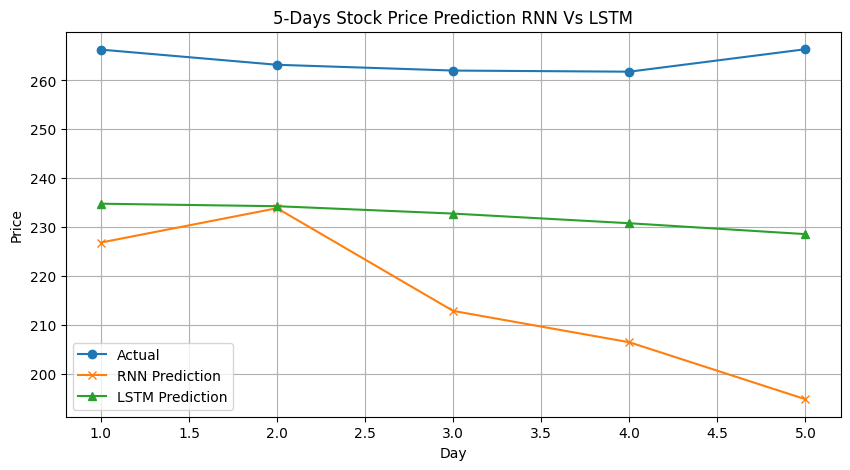

In [92]:
# 5-day predictions
days = list(range(1, 6))  # for 5-day
plt.figure(figsize=(10, 5))
plt.plot(days, np.array(actual_5_days).flatten(), label='Actual', marker='o')
plt.plot(days, np.array(predicted_5_days_rnn).flatten(), label='RNN Prediction', marker='x')
plt.plot(days, np.array(predicted_5_days_lstm).flatten(), label='LSTM Prediction', marker='^')
plt.title("5-Days Stock Price Prediction RNN Vs LSTM")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

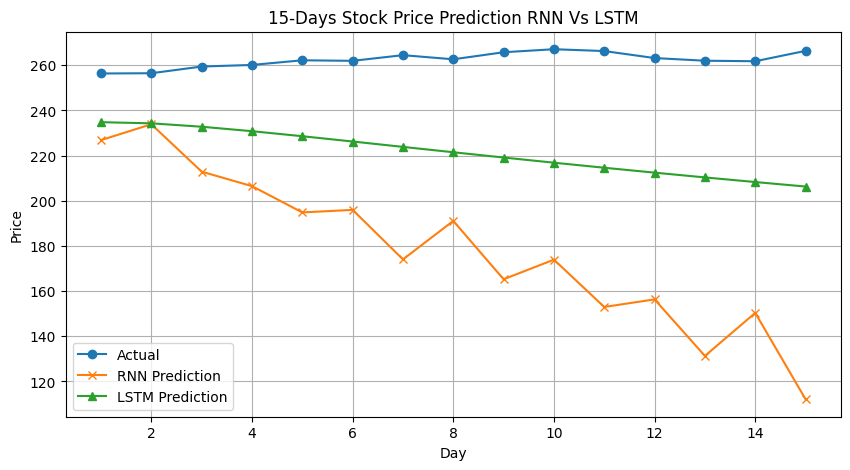

In [93]:
# 15-day predictions
days = list(range(1, 16))  # for 15-day
plt.figure(figsize=(10, 5))
plt.plot(days, np.array(actual_15_days).flatten(), label='Actual', marker='o')
plt.plot(days, np.array(predicted_15_days_rnn).flatten(), label='RNN Prediction', marker='x')
plt.plot(days, np.array(predicted_15_days_lstm).flatten(), label='LSTM Prediction', marker='^')
plt.title("15-Days Stock Price Prediction RNN Vs LSTM")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()